In [1]:
library(tidyverse)
library(RColorBrewer)
library(sf)
library(ggthemes)
library(ggrepel)
library(stringr)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE



In [2]:
# constructor_results <- read_csv("constructor_results.csv", show_col_types = FALSE)
# constructor_standings <- read_csv("constructor_standings.csv", show_col_types = FALSE)
# constructors <- read_csv("constructors.csv", show_col_types = FALSE)
# driver_standings <- read_csv("driver_standings.csv", show_col_types = FALSE)
drivers <- read_csv("drivers.csv", show_col_types = FALSE)
lap_times <- read_csv("lap_times.csv", show_col_types = FALSE)
# pit_stops <- read_csv("pit_stops.csv", show_col_types = FALSE)
# qualifying <- read_csv("qualifying.csv", show_col_types = FALSE)
races <- read_csv("races.csv", show_col_types = FALSE)
# results <- read_csv("results.csv", show_col_types = FALSE)
# seasons <- read_csv("seasons.csv", show_col_types = FALSE)
# sprint_results <- read_csv("sprint_results.csv", show_col_types = FALSE)
# status <- read_csv("status.csv", show_col_types = FALSE)

In [3]:
# Get the fastest lap time for each race
fastest_laps <- lap_times %>%
  group_by(raceId) %>%
  slice_min(order_by = milliseconds, with_ties = FALSE) %>%
  ungroup()

In [4]:
fastest_laps_info <- fastest_laps %>%
  left_join(races, by = "raceId") %>%
  left_join(drivers, by = "driverId") %>%
  select(
    raceId,
    circuitId,
    circuit_name = name, # 'name' from races table
    year,
    driverId,
    driver_code = code,
    driverRef,
    milliseconds,
      time = time.x
  )
fastest_laps_info$driverRef <- str_to_title(fastest_laps_info$driverRef)

In [5]:
# ---- Define regulation eras outside function ----
regulation_changes <- tribble(
  ~start_year, ~end_year, ~regulation_type,
  1998, 2008, "Grooved Tyres & Narrower Cars",
  2009, 2013, "Aerodynamic\nOverhaul\n(KERS/DRS)",
  2014, 2016, "Hybrid Era\n(V6 Turbo)",
  2017, 2021, "Wider Cars & Tyres",
  2022, 2025, "Ground Effect\nEra\n(New Aero Rules)"
)

In [8]:
options(repr.plot.width =15, repr.plot.height =10)

In [9]:
# ---- Function definition ----
plot_fastest_lap_timeline <- function(target_circuit_id, ypos_values) {
  
  # Validate that ypos_values matches the number of rows in regulation_changes
  if (length(ypos_values) != nrow(regulation_changes)) {
    stop("Length of ypos_values must match number of regulation periods.")
  }
  
  # Add y-position column to regulation_changes
  reg_changes_with_y <- regulation_changes %>%
    mutate(
      text_y_pos = ypos_values,
      mid_year = (start_year + end_year) / 2
    )
  
  # --- Data Preparation ---
  fastest_laps <- lap_times %>%
    group_by(raceId) %>%
    slice_min(order_by = milliseconds, with_ties = FALSE) %>%
    ungroup()
  
  fastest_laps_info_with_year <- fastest_laps %>%
    left_join(races, by = "raceId") %>%
    left_join(drivers, by = "driverId") %>%
    select(
      raceId,
      year,
      circuitId,
      circuit_name = name,
      driverId,
      driver_code = code,
      driver_name = driverRef,
      milliseconds,
      time = time.x
    ) %>%
    mutate(fastest_lap_seconds = milliseconds / 1000)
  
  single_circuit_data <- fastest_laps_info_with_year %>%
    filter(circuitId == target_circuit_id) %>%
    arrange(year)
  
  circuit_name_for_title <- single_circuit_data$circuit_name[1]
  
  # --- Determine Y-axis limits ---
  y_min_val <- min(single_circuit_data$fastest_lap_seconds, na.rm = TRUE)
  y_max_val <- max(single_circuit_data$fastest_lap_seconds, na.rm = TRUE)
  y_lim_lower <- floor(y_min_val * 0.95)
  y_lim_upper <- ceiling(y_max_val * 1.05)
  
  # --- Plot ---
  ggplot(single_circuit_data, aes(x = year, y = fastest_lap_seconds, group = 1)) +
    # Regulation shaded areas
    geom_rect(
      data = reg_changes_with_y,
      aes(
        xmin = start_year - 0.5,
        xmax = end_year + 0.5,
        ymin = -Inf,
        ymax = Inf,
        fill = regulation_type
      ),
      inherit.aes = FALSE,
      alpha = 0.2,
      color = NA
    ) +
    geom_vline(
      data = reg_changes_with_y,
      aes(xintercept = start_year - 0.5),
      linetype = "dashed",
      color = "darkgrey",
      linewidth = 0.7
    ) +
    geom_vline(
      xintercept = max(reg_changes_with_y$end_year) + 0.5,
      linetype = "dashed",
      color = "darkgrey",
      linewidth = 0.7
    ) +
    geom_text(
      data = reg_changes_with_y,
      aes(x = mid_year, y = text_y_pos, label = regulation_type),
      inherit.aes = FALSE,
      vjust = 0.5,
      hjust = 0.5,
      size = 5,
      color = "darkslategray",
      fontface = "bold.italic"
    ) +
    geom_area(
      aes(x = year, y = fastest_lap_seconds),
      fill = "steelblue",
      alpha = 0.2,
      color = NA
    ) +
    geom_line(color = "darkblue", linewidth = 0.8, alpha = 0.8) +
    geom_point(color = "darkblue", size = 3) +
    labs(
      title = paste("Fastest Lap Times at", circuit_name_for_title, "Over Years"),
      subtitle = "Highlighting Major F1 Regulation Eras and Driver Performance",
      fill = "Regulation Era"
    ) +
    xlab("Race Year") +
    ylab("Fastest Lap Time (seconds)") +
    theme_fivethirtyeight() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
      plot.title = element_text(size = 24, face = "bold"),
      plot.subtitle = element_text(size = 16, margin = margin(b = 20)),
      axis.title = element_text(size = 16),
      axis.title.x = element_text(margin = margin(t = 16)),
      axis.title.y = element_text(margin = margin(r = 16)),
      legend.position = "none",
      plot.margin = unit(c(1, 1, 1, 1), "cm")
    ) +
    scale_x_continuous(
      breaks = unique(single_circuit_data$year),
      labels = unique(single_circuit_data$year)
    ) +
    scale_fill_brewer(palette = "Set3") +
    coord_cartesian(ylim = c(y_lim_lower, y_lim_upper))
}

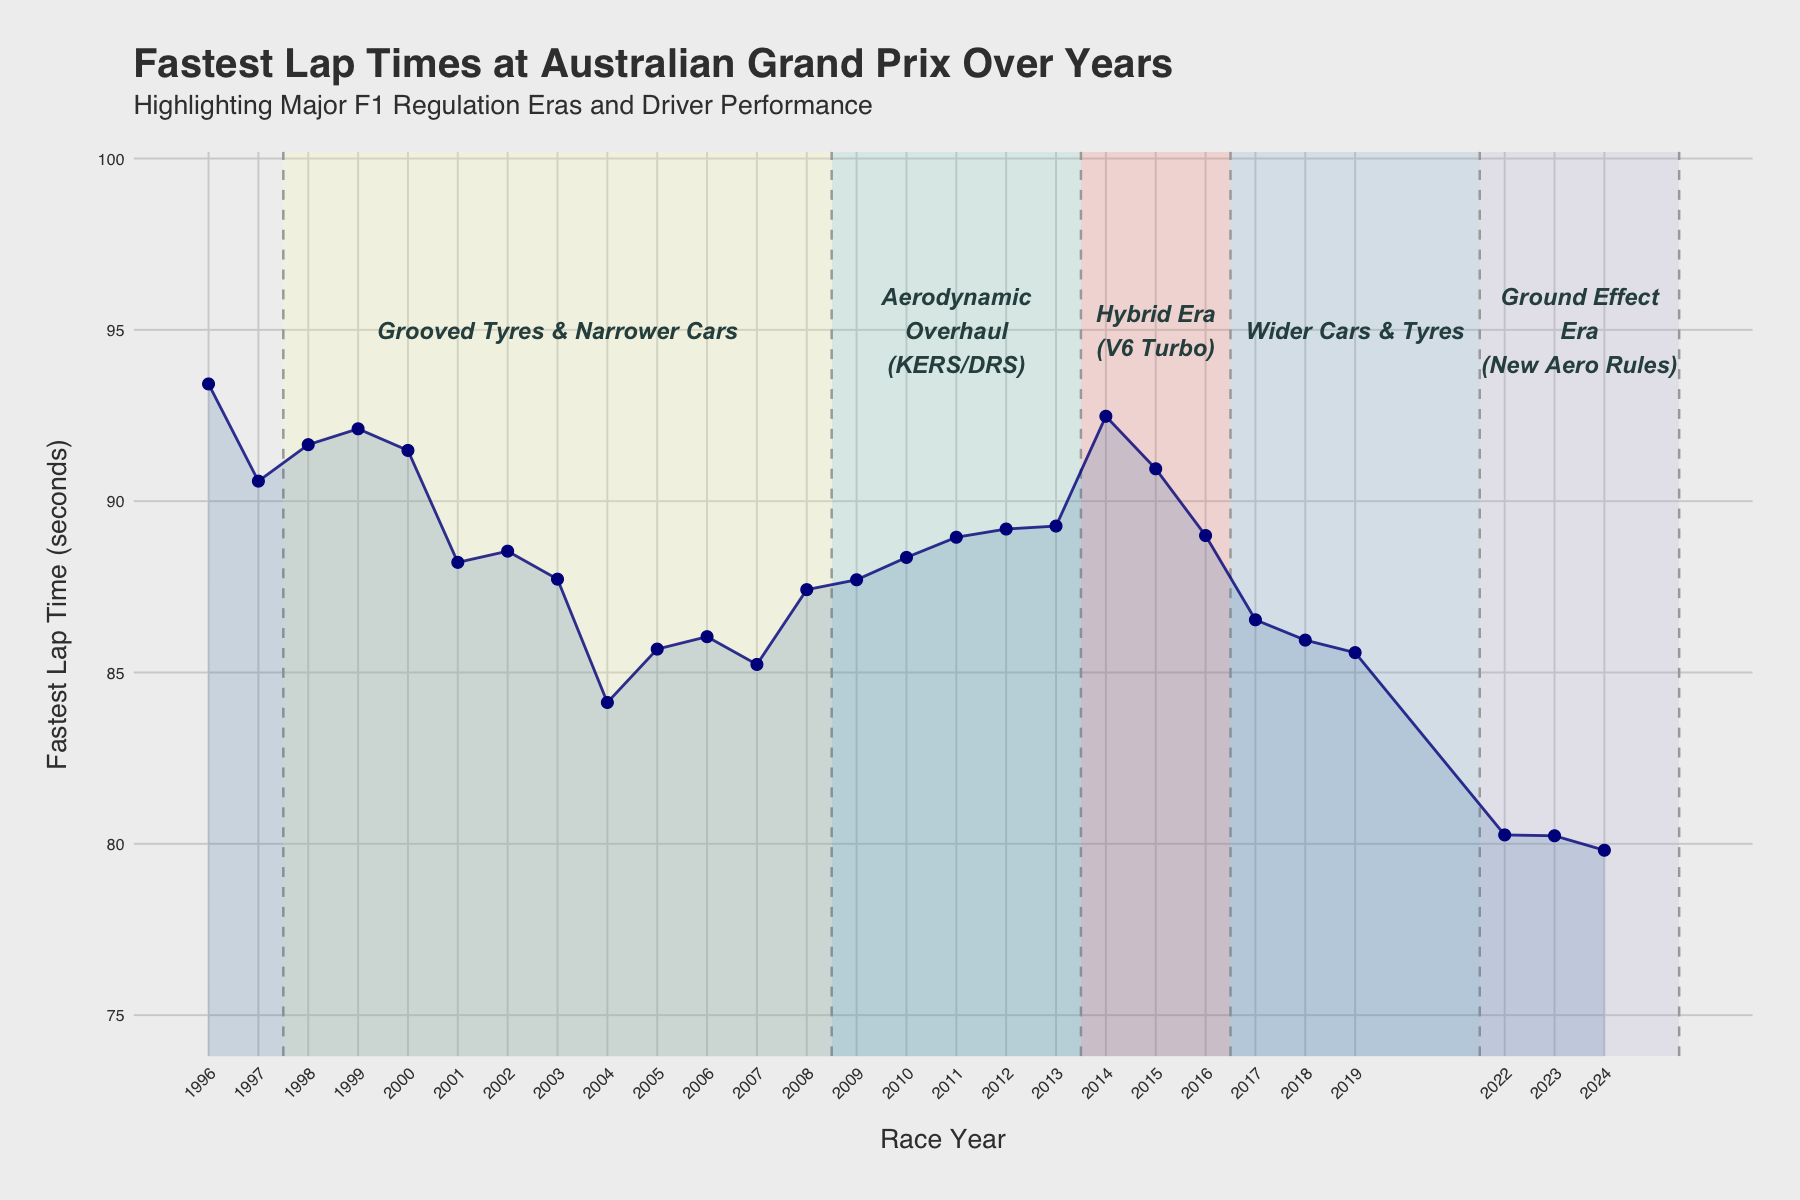

In [10]:
plot_fastest_lap_timeline(1, rep(95,5))

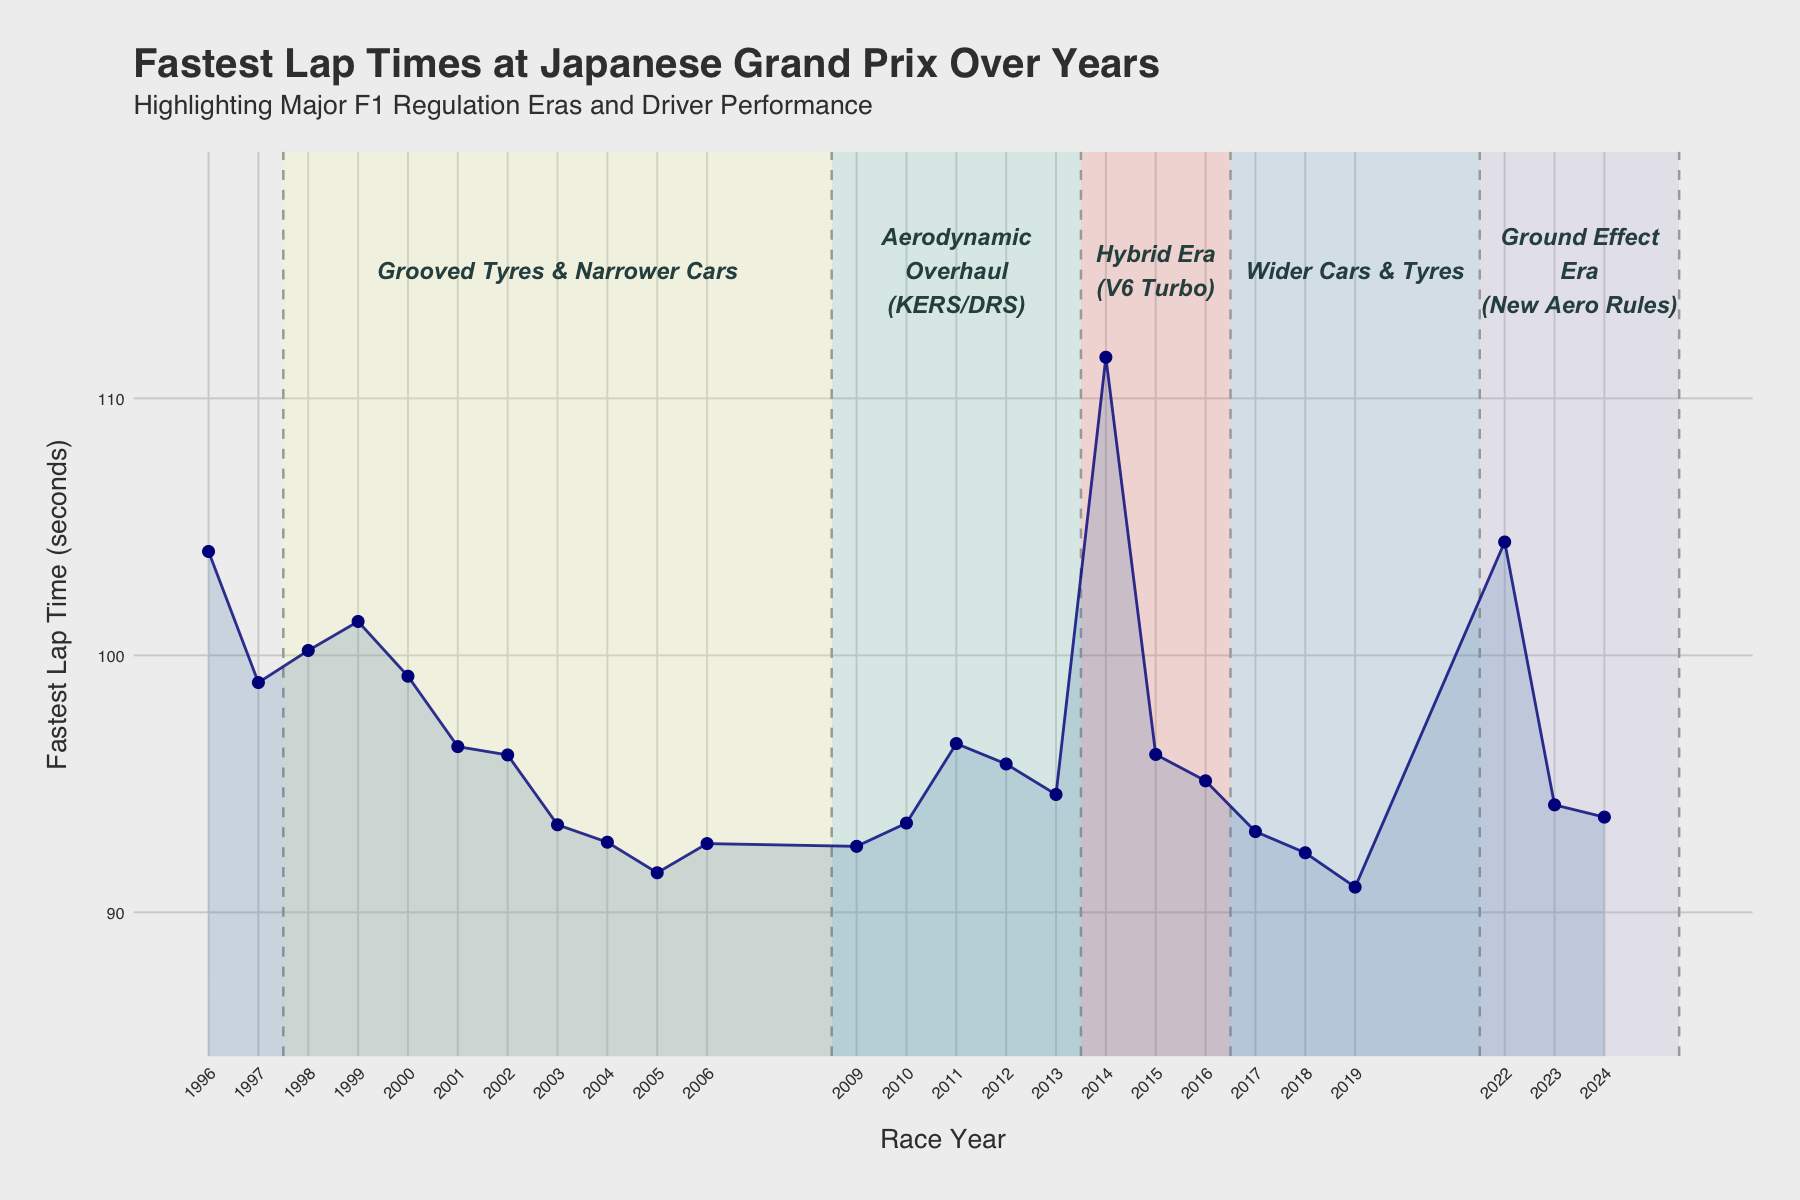

In [14]:
plot_fastest_lap_timeline(22, rep(115,5))


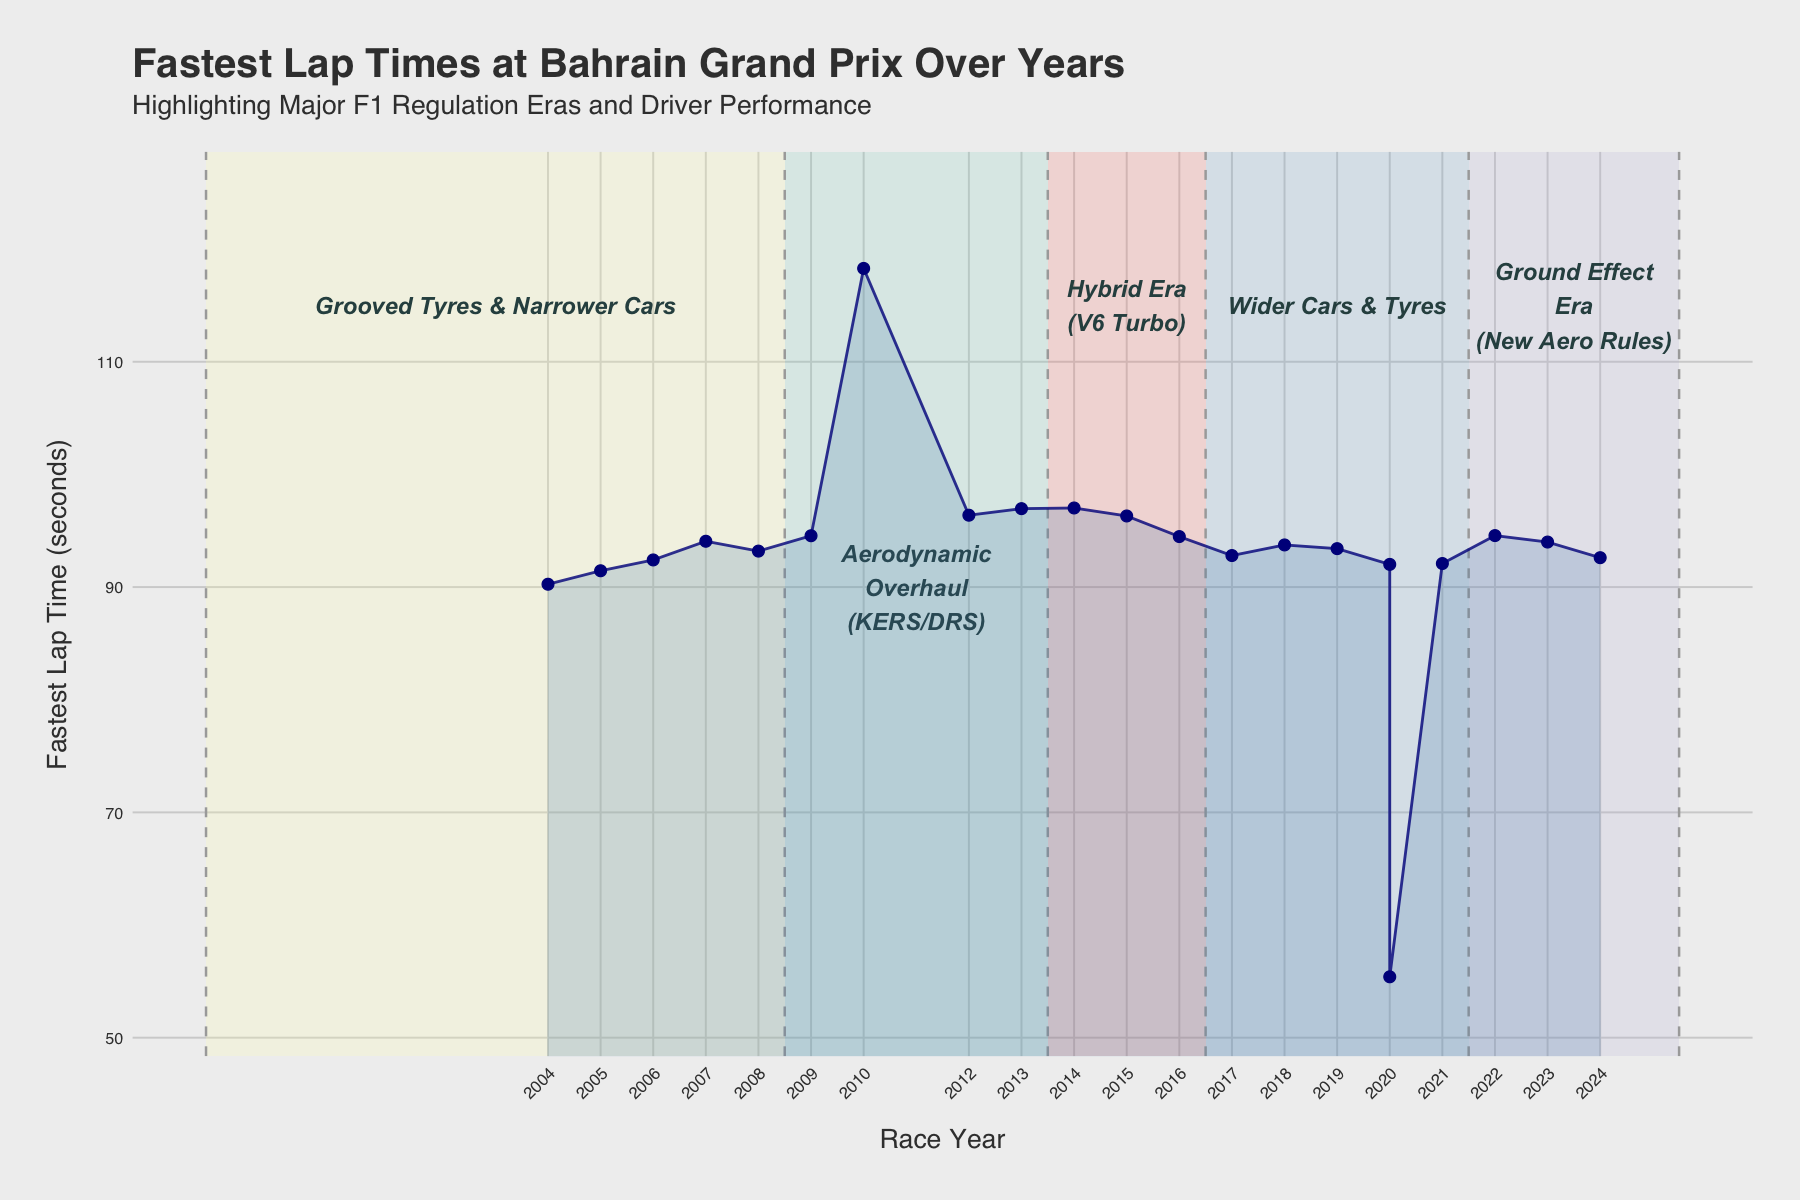

In [25]:
plot_fastest_lap_timeline(3, c(115,90 ,115,115,115))

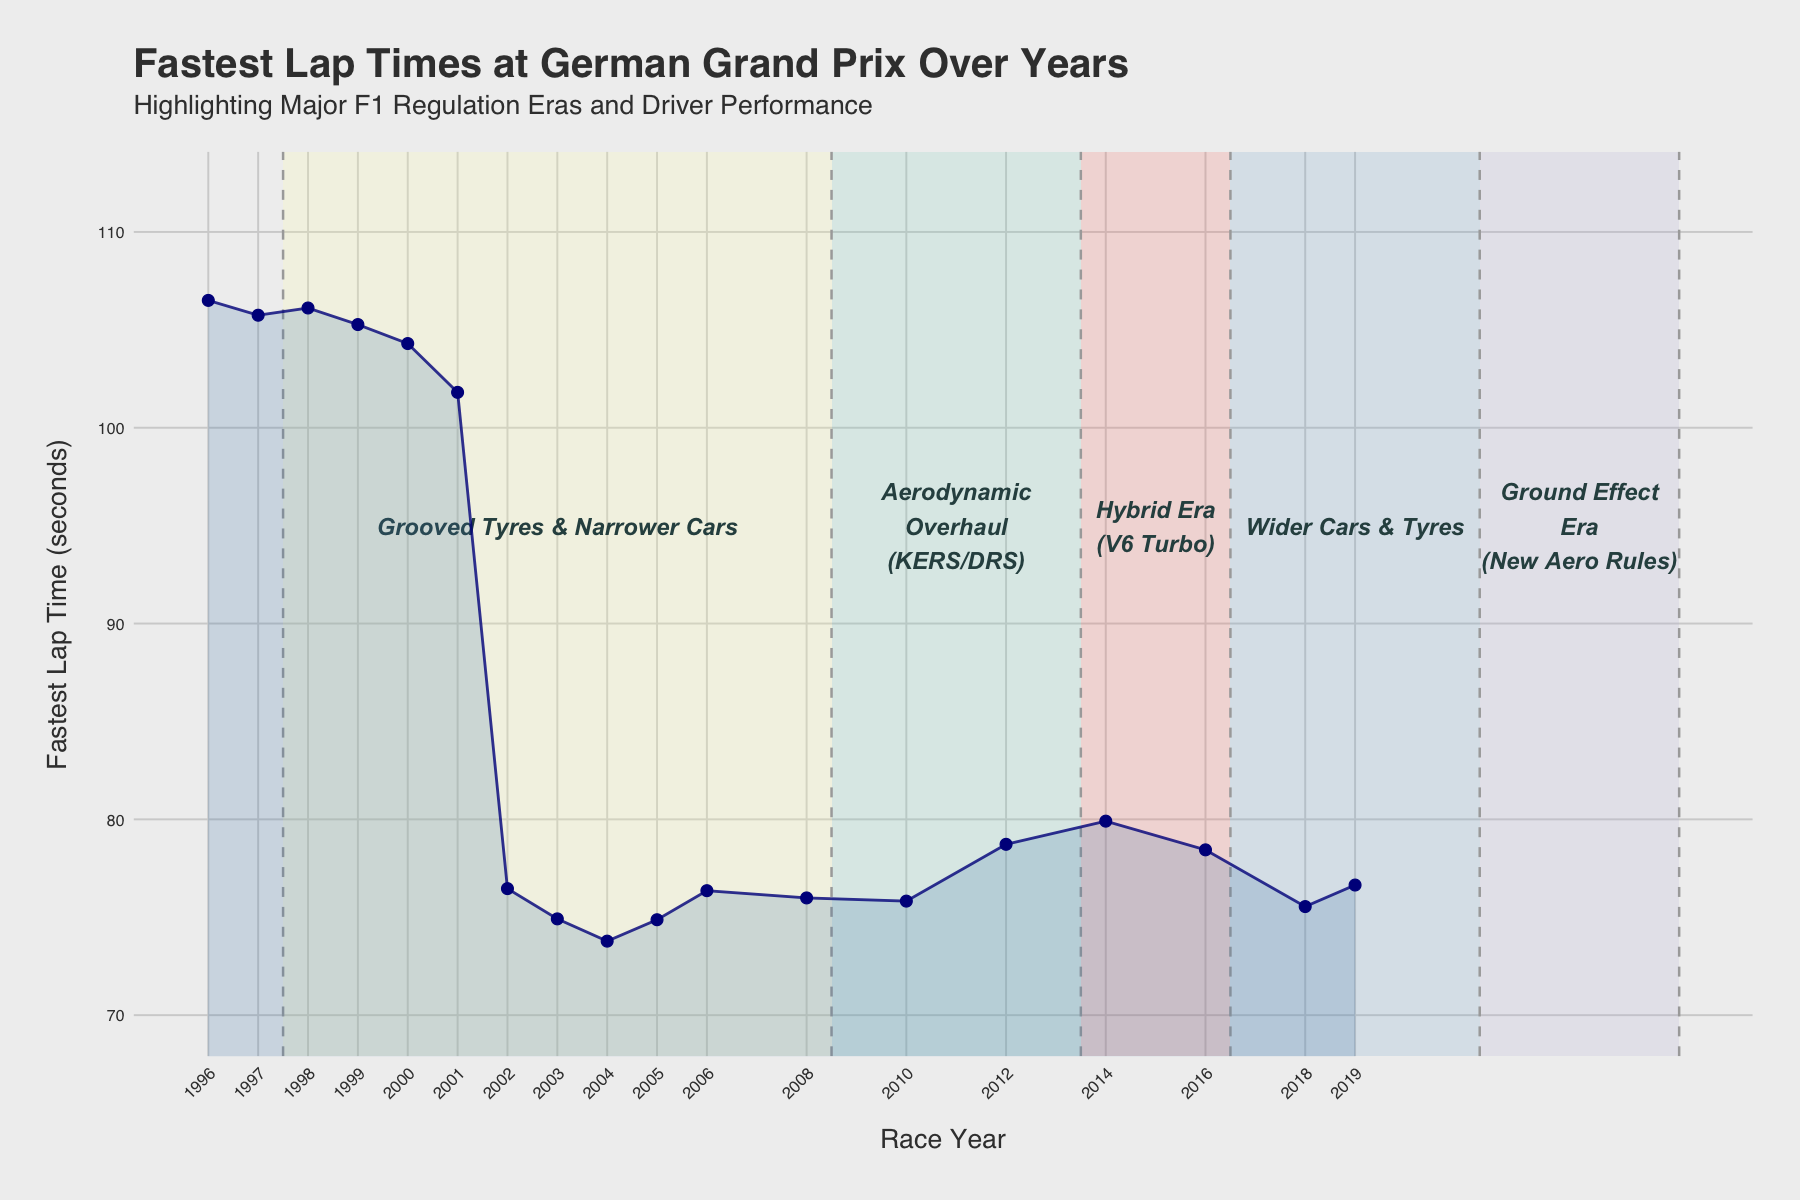

In [49]:
(plot4<-plot_fastest_lap_timeline(10, rep(95,5)))

In [34]:
ggsave("Fastest-Lap-Times-At-Grand-Prix-Over-Years6.png", plot = plot4, width = 15, height = 10, dpi = 300)